In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from model import InvertedPendulum, massSpringDamper
import matplotlib.animation as animation
from functools import partial

In [2]:
class PID_controller():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd

    def action(self, error, errorDot, errorInt):
        return self.kp*error + self.ki*errorInt + self.kd*errorDot
    
class stateFeedback_controller():
    def __init__(self, gain):
        self.gain = gain
    
    def action(self, state):
        return np.dot(self.gain, state)
    
def update(frame, theta_arr, pendCen, pendLen, line): #function for creating animation
    theta = theta_arr[frame]
    x = [pendCen[0], pendCen[0] - pendLen*np.sin(theta)]
    z = [pendCen[1], pendCen[1] - pendLen*np.cos(theta)]
    line.set_xdata(x)
    line.set_ydata(z)
    return line

In [16]:
def main():
    m_ivp = 1
    k_ivp = 1
    l_ivp = 1
    g = 9.8
    procNoiseCov = 1
    mesNoiseCov = 1
    isDisturb_ivp = 0

    inverted_pendulum = InvertedPendulum(m_ivp, l_ivp, g, k_ivp, isDisturb_ivp, procNoiseCov, mesNoiseCov)

    pid_controller = PID_controller(10,0,0)

    sim_time = 5

    sim_dt = 0.05
    
    theta_0 = np.pi/2
    theta_T = np.pi
    omega_0, omega_T = 0,0

    #implementing PID
    error_p = 0
    theta = theta_0
    omega = omega_0
    theta_array = [theta]
    omega_array = [omega]
    error_int = 0
    time_array = [0]
    u_pid_array = []
    error_array = []
    for time in np.arange(0, sim_time, sim_dt):
        error = theta_T - theta
        error_dot = (error - error_p)/sim_dt
        error_int += error*sim_dt
        u_pid = pid_controller.action(error, error_dot, error_int)
        theta_next, omega_next = inverted_pendulum.nextState([theta, omega], u_pid, sim_dt)
        theta, omega = theta_next, omega_next
        theta_array.append(theta)
        omega_array.append(omega)
        time_array.append(time+sim_dt)
        u_pid_array.append(u_pid)
        error_array.append(error)

    plt.figure(1)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, theta_array)
    ax1.title.set_text('theta')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array, omega_array)
    ax2.title.set_text('omega')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:-1], u_pid_array)
    ax3.title.set_text('control')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:-1], error_array)
    ax4.title.set_text('error')

    #implementing state feedback assuming full state is available

    x_T = np.array([[theta_T],[omega_T]])
    x_0 = np.array([[theta_0],[omega_0]])
    omega_array_sf = [omega_0]
    theta_array_sf = [theta_0]
    #x_array_sf = [x_0]
    x_array_sf = np.zeros((2, int(sim_time/sim_dt+1)))
    x_array_sf[0,0] = x_0[0,0]
    x_array_sf[1,0] = x_0[1,0]
    u_sf_array = []
    error_sf_array = []
    x = np.copy(x_0)
    x_hat = np.copy(x_0)
    p_hat = np.identity(2)
    B_mat = inverted_pendulum.BMatt()
    C_mat = inverted_pendulum.CMatt
    D_mat = inverted_pendulum.DMatt
    for time in np.arange(0, sim_time, sim_dt):
        A_mat = inverted_pendulum.AMatt(x[0,0])
        d_syst = sc.signal.cont2discrete((A_mat, B_mat, C_mat, D_mat), sim_dt)

        poles = np.array([-10,-25])
        K_mat = sc.signal.place_poles(A_mat, B_mat, poles).gain_matrix
        u_ss = inverted_pendulum.m*g*inverted_pendulum.l/2*np.cos(x[0,0])*(x_T[0,0] - x_hat[0,0])
        #print('u_ss - ', u_ss, 'K_mat - ',  K_mat, 'diff - ', x_T - x)
        u_tot = u_ss + np.dot(K_mat,(x_T - x_hat))[0,0]
        # print('mat prod', np.dot(K_mat,(x_T - x))[0,0])
        # print('u_tot', u_tot[0, 0])
        
        theta_next, omega_next = inverted_pendulum.nextState([x[0,0], x[1,0]], u_tot, sim_dt)
        if theta_next > 2*np.pi:
            print('it happened')
            theta_next = theta_next % (2*np.pi)
        elif theta_next < 0:
            print('it happened1')
            theta_next = 2*np.pi - ((-theta_next) % (2*np.pi))
        x = np.array([[theta_next],[omega_next]])
        y_meas = inverted_pendulum.measurement(x)

        Phi, Gamma, C_d = d_syst[0], d_syst[1], d_syst[2]
        Gamma_d = np.copy(Gamma)
        x_pred = np.dot(Phi, x_hat) + np.dot(Gamma, u_tot)
        p_pred = Phi @ p_hat @ np.transpose(Phi) + Gamma_d @ np.transpose(Gamma_d)*procNoiseCov
        #print(p_pred, C_d)
        kalman_gain = (p_pred @ np.transpose(C_d)) @ np.linalg.inv(C_d @ p_pred @ np.transpose(C_d) + mesNoiseCov)
        x_hat = x_pred + kalman_gain @ (y_meas - C_d @ x_pred)
        p_hat = p_pred - kalman_gain @ C_d @ p_pred
        
        theta_array_sf.append(theta_next)
        omega_array_sf.append(omega_next)
        u_sf_array.append(u_tot)
        error_sf_array.append(theta_T - theta_next)
        
        #print(int(time/sim_dt + 1))
        x_array_sf[0,int(time/sim_dt + 1)] = x[0,0]
        x_array_sf[1,int(time/sim_dt + 1)] = x[1,0]    
        #x_array_sf.append(x)
    #print('theta_sf', x_array_sf)
    plt.figure(2)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, theta_array_sf)
    ax1.title.set_text('theta')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array,  omega_array_sf)
    ax2.title.set_text('omega')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:-1], u_sf_array)
    ax3.title.set_text('control')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:-1], error_sf_array)
    ax4.title.set_text('error')


    #creating animation
    fig, ax = plt.subplots()
    pendCent = [2,2]
    offset = [-l_ivp*np.sin(theta_0), -l_ivp*np.cos(theta_0)]
    pendEnd = pendCent + offset

    line = ax.plot([pendCent[0], pendEnd[0]], [pendCent[1], pendEnd[1]], 'k-', linewidth=3)[0]
    ax.plot(pendCent[0], pendCent[1], 'kx')
    ax.plot(pendEnd[0], pendEnd[1], 'ro')
    print(pendEnd)
    ax.set(xlim = [0,4], ylim = [0,4], xlabel = "x", ylabel = "z")
    #ax.set_aspect('equal')
    plt.gca().set_aspect('equal')
    plt.axis('off')
    ani = animation.FuncAnimation(fig=fig, func=partial(update, theta_arr = theta_array_sf, pendCen = pendCent, pendLen = l_ivp, line = line), frames=int(sim_time/sim_dt), interval = int(sim_dt*1000))
    #writervideo = animation.FFMpegWriter(fps=60) 
    ani.save('Invpend_SF.gif')#, writer=writervideo) 
    plt.close
      
        
        

    

[2, 2, -1.0, -6.123233995736766e-17]


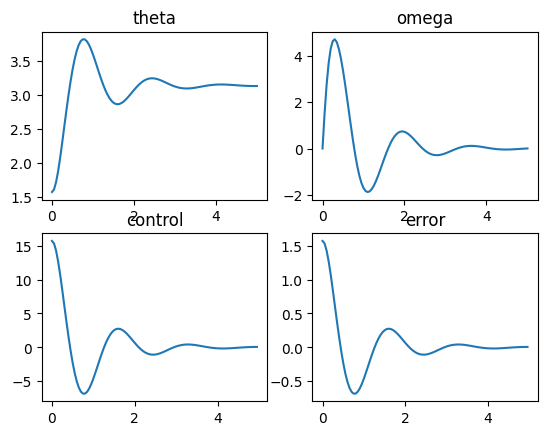

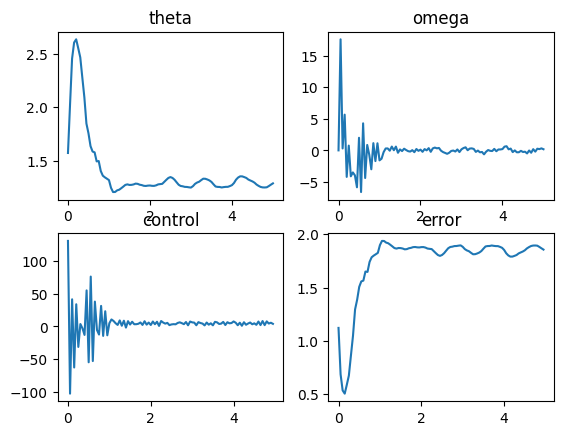

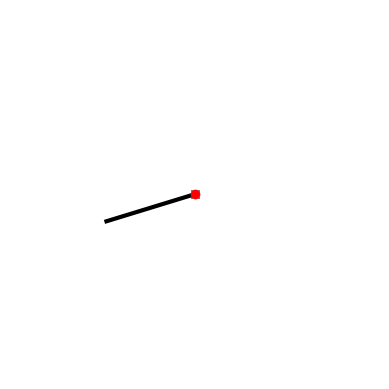

In [17]:
if __name__ == '__main__':
    main()
    

In [5]:
invPend= InvertedPendulum(1, 1, 9.8, 1, False)
syst = sc.signal.lti(invPend.AMatt(np.pi),invPend.BMatt(), invPend.CMatt )
d_syst = sc.signal.cont2discrete((invPend.AMatt(np.pi),invPend.BMatt(), invPend.CMatt, invPend.DMatt), 0.05)
print(d_syst[0])
print(invPend.AMatt(np.pi))

[[1.01754278 0.04671548]
 [0.68671753 0.87739634]]
[[ 0.   1. ]
 [14.7 -3. ]]


In [4]:
np.random.normal(1,1,1)[0]

0.6197713563862546

In [9]:
np.linalg.inv([[2]])

array([[0.5]])